In [18]:
import pandas as pd
import numpy as np
import math
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

file_name='RM_MCs.csv'


df=pd.read_csv(file_name,parse_dates=True,index_col='date_of_service_dttm')

print(df.shape[0])
print('number of patients:',len(df.mrn.unique()))
print (df.head())

### strain out val dfs
# df_val=pd.read_csv('UC_recurrent_mrns.csv')
# try:
#     df_val.MRN=df_val.MRN.str.replace('-','')
#     df_val.MRN=df_val.MRN.astype('int64')
# except:
#     print('mrns are already in correct form')
    
# mrns_val=df_val.MRN.unique()
    
# df=df[~df['mrn'].isin(mrns_val)]
# print('number of patients without val cohort:',len(df.mrn.unique()))

### strain out people that start with RM=1 and have super long notes
mrns=df.mrn.unique()
good_mrns=[]
for mrn in mrns:
    sub_df=df[df['mrn']==mrn]
    if sub_df.iloc[0]['is_RM'] != 1:
        good_mrns.append(mrn)
df=df[df['mrn'].isin(good_mrns)]
print('number of patients that start without disease:',len(df.mrn.unique()))



7397
number of patients: 171
                          mrn  is_RM
date_of_service_dttm                
1996-02-26            2050963      0
2009-01-23            2050963      0
2009-10-01            2050963      0
2010-02-19            2050963      0
2010-03-01            2050963      0
number of patients that start without disease: 149


In [19]:
### convert to monthly
# create sub df by mrn

def convert_to_monthly(df):
    ptx_info=df_by_patient(df)
    for index,ptx in enumerate(ptx_info):
        ptx_info[index]=to_monthly(ptx)
    
    for index,ptx in enumerate(ptx_info):
        months=[]
        for i in range(ptx.shape[0]):
            months.append(i+1)
        ptx_info[index]['month']=months
    df_rebuilt=rebuild_df(ptx_info)
    return df_rebuilt
    
    
def df_by_patient(df):
    '''returns a list of dataframes divided by mrn'''
    ptx_info=[]
    for index,mrn in enumerate(df.mrn.unique()):
        sub_df=df[df['mrn']==mrn]
        ptx_info.append(sub_df)
    return ptx_info

# ptx_info=df_by_patient(df)
### re index to monthly

def to_monthly(df_input):
    df_working=df_input

    df_d=df_working.resample('D').mean()
    df_d['mrn']=df_d['mrn'].ffill()
    df_d['is_RM']=df_d['is_RM'].ffill()

    df_m=df_d.resample('M').mean()
    df_m.is_RM.value_counts()

    df_m['is_RM']=df_m['is_RM'].apply(lambda a:a>0).astype(int)
    return df_m

def rebuild_df(ptx_info):
    df_rebuilt=''
    for index,ptx in enumerate(ptx_info):
        if index==0:
            df_rebuilt=ptx_info[0]
        else:
            df_rebuilt=df_rebuilt.append(ptx)
    return df_rebuilt

# for index,ptx in enumerate(ptx_info):
#     ptx_info[index]=to_monthly(ptx)
# print (len(ptx_info))
# print (ptx_info[0])

df_rebuilt=convert_to_monthly(df)
print (df_rebuilt)
# ptx_info=df_by_patient(df_rebuilt)
# for index,ptx in enumerate(ptx_info):
#     months=range(1,ptx.shape[0])
#     ptx_info['month']=months
# df_rebuilt=rebuild_df(ptx_info)

                            mrn  is_RM  month
date_of_service_dttm                         
1996-02-29            2050963.0      0      1
1996-03-31            2050963.0      0      2
1996-04-30            2050963.0      0      3
1996-05-31            2050963.0      0      4
1996-06-30            2050963.0      0      5
...                         ...    ...    ...
2018-07-31            3447668.0      0      3
2018-08-31            3447668.0      0      4
2018-09-30            3447668.0      0      5
2018-10-31            3447668.0      0      6
2018-11-30            3447668.0      0      7

[7625 rows x 3 columns]


In [20]:
def getTransitionMatrix(df):
    '''given a dataframe with mrn and states represented as last_RM, return a transition matrix'''
    transition_matrix_counts=[[0,0],[0,0]]
    transition_matrix_counts=np.array(transition_matrix_counts)
    
    mrns=df.mrn.unique()
    ptx_info=[]
    for mrn in mrns:
        df_sub=df[df['mrn']==mrn]
        ptx_info.append(df_sub)

    for ptx in ptx_info:
        # get transition matrix counts
        df_working=ptx
        df_working['last_RM']=df_working['is_RM'].shift(1)
        for index,row in df_working.iterrows():
            last_RM=row['last_RM']
            RM=row['is_RM']

            if last_RM==0 and RM==0:
                transition_matrix_counts[0][0]+=1
            elif last_RM==0 and RM==1:
                transition_matrix_counts[0][1]+=1
            
        transition_matrix_counts[1][0]=0
            
        transition_matrix_counts[1][1]=1

    transition_matrix=transition_matrix_counts/transition_matrix_counts.sum(axis=1)[:,None]
    transition_matrix=np.nan_to_num(transition_matrix)
    #print (transition_matrix_counts)
    #print (transition_matrix)
    return transition_matrix
    
transition_matrix=getTransitionMatrix(df_rebuilt)
print (transition_matrix)

C:\Users\12488\python\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


[[0.96435331 0.03564669]
 [0.         1.        ]]


In [21]:
### produce transition matrices for every 12 month increment in the data (up to 5 years), then rest
import math

def get_Time_Dependent_TMs(df,states=3,months_in_window=12):
    df_working=df
    cutoffs=[]
    for state in range(states-1):
        co=(state+1)*months_in_window
        cutoffs.append(co)
    dfs=[]
    for cutoff in cutoffs:
        df_sub=df_working[df_working['month']<=cutoff]
        dfs.append(df_sub)
        df_working=df_working[df_working['month']>cutoff]
    dfs.append(df_working)
    TMs=[]
    for d in dfs:
        TM=getTransitionMatrix(d)
        TMs.append(TM)
    
    ### make monotonic
    for index,TM in enumerate(TMs):
        if index != len(TMs)-1:
            P_change=TMs[index][0][1]
            P_change_next=TMs[index+1][0][1]
            if P_change_next>P_change:
                # change probability of changing
                TMs[index+1][0][1]=P_change
                # change probabilty of staying the same
                TMs[index+1][0][0]=1-P_change
    
    return TMs



TMs=get_Time_Dependent_TMs(df_rebuilt)
for index,TM in enumerate(TMs):
    print (TM)

C:\Users\12488\python\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


[[0.93710119 0.06289881]
 [0.         1.        ]]
[[0.97888676 0.02111324]
 [0.         1.        ]]
[[0.98070296 0.01929704]
 [0.         1.        ]]


In [22]:
class MarkovChain(object):
    def __init__(self,transition_matrix,states):
        self.transition_matrix=np.atleast_2d(transition_matrix)
        self.states=states
        self.index_dict={self.states[index]:index for index in range(len(self.states))}
        self.state_dict={index: self.states[index] for index in range(len(self.states))}
    def next_state(self,current_state):
        return np.random.choice(
        self.states,
        p=self.transition_matrix[self.index_dict[current_state], :]
        )
    def generate_states(self,current_state,no=10):
        future_states=[]
        for i in range(no):
            next_state=self.next_state(current_state)
            future_states.append(next_state)
            current_state=next_state
        return future_states
    
def produceMCSimulationData(n_chains,TMs,months=60):
    '''give input of number of chains for iteration, returns a df simulating MC for that population'''
    data=[]
    ### select number of chains to produce
    for i in range(n_chains):
        ### code to generate markov chains - iterates through the series of TMs for risk in years 1,2,3,4,5,6+
        for index,TM in enumerate(TMs):
            disease_chain=MarkovChain(transition_matrix=TM,states=[0,1])
            if index==0:
                l=disease_chain.generate_states(current_state=0,no=12)
                chain=l
            elif index+1==len(TMs):
                l=l=disease_chain.generate_states(current_state=chain[-1],no=months-len(chain))
                chain=chain+l
            else:
                l=disease_chain.generate_states(current_state=chain[-1],no=12)
                chain=chain+l
        for month, state in enumerate(chain):
            data.append([i,month,state])
    df_MC=pd.DataFrame(data=data,columns=['ID','month','state'])
    return df_MC

### Kaplan Meier
### get T and E for each ID
def get_df_KM(df):
    df_MC=df.sort_values(by='month',ascending=True)
    ptx_info=[]
    for ID in df_MC.ID.unique():
        sub_df=df_MC[df_MC.ID==ID]
        ptx_info.append(sub_df)
    data_KM=[]
    for index,ptx in enumerate(ptx_info):
        df_working=ptx_info[index]

        T=0
        cont=True
        for index,row in df_working.iterrows():
            if cont:
                if row['state']==1:
                    T=row['month']
                    cont=False
        if cont==True:
            T=df_working.iloc[-1]['month']
        
        E=df_working.iloc[-1]['state']
        data_KM.append([df_working.iloc[0]['ID'],T,E])
    df_KM=pd.DataFrame(data=data_KM, columns=['ID','T','E'])
    return df_KM

#df_MC=produceMCSimulationData(50)
#print (df_MC)
#df_KM=get_df_KM(df_MC)
#print (df_KM)

### generate kaplan-meier estimator
def get_averaged_model(TMs):
    kmf=KaplanMeierFitter()
    survival_cohort=''
    for i in range(10):
        df_MC=produceMCSimulationData(n_chains=50,TMs=TMs,months=60)
        df_KM=get_df_KM(df_MC)
        T=df_KM['T']
        E=df_KM['E']
        kmf.fit(T, E, label='model')
        l=[i for i in range(60)]
        s=kmf.predict(l)
        if i==0:
            survival_cohort=s
        else:
            survival_cohort=pd.concat([survival_cohort,s],axis=1)

    survival_cohort['mean']=survival_cohort.mean(axis=1)
    #survival_cohort['std']=survival_cohort.std(axis=1)
    survival_cohort['RM_out_of_1000']=(1-survival_cohort['mean'])*1000
    survival_cohort['affected']=survival_cohort['RM_out_of_1000'].diff()
    survival_cohort['affected']=survival_cohort['affected'].fillna(survival_cohort.iloc[0]['RM_out_of_1000'])
    #print (survival_cohort)

    ### get T and E
    data=[]
    for index,row in survival_cohort.iterrows():
        month=index+1
        n=row['affected']
        for i in range(int(n)):
            data.append([month,1])
    while len(data)<1000:
        data.append([60,0])
    df_KM=pd.DataFrame(data=data, columns=['T','E'])
    return df_KM
# df_KM=get_averaged_model()
# print (df_KM)

In [23]:
### do everything at once
def model_MCMC(df,mrns=[],states=3,months_in_window=12):
    df_to_use=df
    if len(mrns)>=1:
        df_to_use=df[df['mrn'].isin(mrns)]
    # convert to monthly
    df_monthly=convert_to_monthly(df_to_use)
    
    #### ADD FILTER FOR TIMELINES THAT AREN"T SUPER LONG
    
    
    # get transition matrices
    TMs=get_Time_Dependent_TMs(df_monthly,states=states,months_in_window=months_in_window)
    for TM in TMs:
        print (np.array_str(TM))
    # make model
    df_KM=get_averaged_model(TMs)
    return df_KM
#df_KM=model_MCMC(df)

572
1055
48
93


C:\Users\12488\python\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


[[0.94827586 0.05172414]
 [0.         1.        ]]
[[0.98445596 0.01554404]
 [0.         1.        ]]
[[0.98445596 0.01554404]
 [0.         1.        ]]


C:\Users\12488\python\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


[[0.93390805 0.06609195]
 [0.         1.        ]]
[[0.97368421 0.02631579]
 [0.         1.        ]]
[[0.9798995 0.0201005]
 [0.        1.       ]]
Never User: median time to RM: 15.0 months
12    0.533
24    0.434
36    0.339
48    0.284
60    0.254
Name: never user, dtype: float64
Current/Former User: median time to RM: 11.0 months
12    0.446
24    0.333
36    0.258
48    0.211
60    0.170
Name: current/former user, dtype: float64


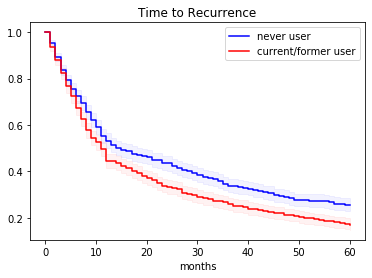

In [24]:
from lifelines.statistics import logrank_test

### load tobacco data
df_smoke=pd.read_csv('RM_Database.csv')
df_never_used=df_smoke[df_smoke['TOBACCO_USER']=='Never']
mrns_never=df_never_used.mrn.unique()
print (len(mrns_never))

df_has_used=df_smoke[(df_smoke['TOBACCO_USER']=='Yes')|(df_smoke['TOBACCO_USER']=='Quit')]
mrns_have=df_has_used.mrn.unique()
print (len(mrns_have))

#get patients that never smoked in cohort
df_control=df[df['mrn'].isin(mrns_never)]
df_users=df[df['mrn'].isin(mrns_have)]

mrns1=df_control.mrn.unique()
mrns2=df_users.mrn.unique()

print (len(mrns1))
print (len(mrns2))

df_1=model_MCMC(df,mrns1,states=3)
df_2=model_MCMC(df,mrns2,states=3)


T=df_1['T']
E=df_1['E']
T_smoke=df_2['T']
E_smoke=df_2['E']

kmf=KaplanMeierFitter()
kmf.fit(T, E, label='never user')
ax = kmf.plot(ci_show=True,ci_alpha=0.05,color='Blue')
print('Never User: median time to RM:',kmf.median_survival_time_,'months')
print(kmf.predict([12,24,36,48,60]))

kmf.fit(T_smoke, E_smoke, label='current/former user')
ax = kmf.plot(ax=ax,ci_show=True,ci_alpha=0.05,color='Red')
print('Current/Former User: median time to RM:',kmf.median_survival_time_,'months')
print(kmf.predict([12,24,36,48,60]))
plt.title('Time to Recurrence')
plt.xlabel('months')

#log rank
results = logrank_test(T, T_smoke, event_observed_A=E, event_observed_B=E_smoke)
results.print_summary()

plt.savefig('MC_Survival_Curves_Tobacco_Use.png')

